# Reformat data

## Summary

Reformat data for descriptive analysis.

## Aims

Restrict clean data (from 01_clean_raw_data.ipynb) to:
* Years of 2017 to 2019.
* Hospitals with at least 20 admissions per year.
* Patients who arrived by ambulance.

## Set up

In [1]:
# Linting
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
# Import packages and functions
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [3]:
# Set paths and filenames
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and files.'''

    data_path = './../output/'
    data_filename = 'reformatted_data.csv'
    restrict_filename = 'reformatted_data_restricted.csv'
    notebook = '01'


paths = Paths()

In [4]:
# Load data
raw_data = pd.read_csv(os.path.join(paths.data_path, paths.data_filename))

## Functions

In [5]:
def check_criteria(data, min_admissions, min_thrombolysis, output):
    '''
    Checks whether hospitals meet the restriction criteria:
    - min_admissions (minimum number of admissions per year)
    - min_thrombolysis (minimum number of thrombolysis patients per year)

    Use output to choose what to return, either:
    - keep (dataframe with all records from hospitals that met the criteria)
    - discard (dataframe with number of admissions and thrombolysis patients
    per year at hospitals that did not meet the criteria))
    '''
    # Create empty objects to store rows, depending on whether meet criteria
    discard = []
    keep = []

    # Loop through name (each stroke team) and group_df (relevant rows
    # from data)
    groups = data.groupby('stroke_team')
    for name, group_df in groups:
        # Find admissions and thrombolysis use per year
        test_restrictions = pd.concat(
            [group_df.groupby('year').size().rename('admissions'),
             group_df.groupby('year')['thrombolysis'].sum()],
            axis=1).reset_index()
        test_restrictions['stroke_team'] = name
        # Check if any fail conditions
        if ((any(test_restrictions['admissions'] < min_admissions)) or
                (any(test_restrictions['thrombolysis'] < min_thrombolysis))):
            discard.append(test_restrictions)
        else:
            keep.append(group_df)

    # Return specified output
    if output == 'keep':
        return_ob = pd.concat(keep)
    elif output == 'discard':
        return_ob = pd.concat(discard)
    return return_ob

In [6]:
def plot_admissions_thrombolysis(admission_thrombolysis_data):
    '''
    Creates plot of number of admissions and number of thrombolysis
    patients per year per stroke team in the provided dataset
    '''
    # Group by stroke team and loop through
    admissions_thrombolysis_teams = (
        admission_thrombolysis_data.groupby('stroke_team'))

    # Set up figure and counter
    fig, ax = plt.subplots(figsize=(5, 10),
                           nrows=len(admissions_thrombolysis_teams), ncols=2)
    i = 0

    plt.setp(ax, xticks=[2017, 2018, 2019])

    # Loop through teams and plot
    for name, group_df in admissions_thrombolysis_teams:
        # Admissions plot
        group_df.plot(x='year', y='admissions', linestyle='-', marker='o',
                      ax=ax[i, 0], color='blue', legend=False, xlabel='')
        ax[i, 0].hlines(y=20, xmin=2017, xmax=2019, color='grey')
        ax[i, 0].set_ylim([0, None])
        ax[i, 0].set_title(name, fontsize=8)

        # Thrombolysis patients plot
        group_df.plot(x='year', y='thrombolysis', linestyle='-', marker='o',
                      ax=ax[i, 1], color='red', legend=False, xlabel='')
        ax[i, 1].hlines(y=0, xmin=2017, xmax=2019, color='grey')
        ax[i, 1].set_ylim([0, None])
        ax[i, 1].set_title(name, fontsize=8)

        i += 1

    fig.tight_layout()
    fig.suptitle('Admissions (left) and thrombolysis (right)')
    fig.subplots_adjust(top=0.93)
    plt.show()

## Restrict by year

Restrict to records from 2017 to 2019 because:
* 2016 is quite old
* 2020 onwards is impacted by the COVID pandemic.

In [7]:
raw_data_years = raw_data[raw_data['year'].isin([2017, 2018, 2019])]

In [8]:
# Printing change in number of records due to restricting years
print(f'''
Number of records per year:
{raw_data.year.value_counts().sort_index().to_string()}
Total records (all years): {len(raw_data.index)}
Total records (2017-19): {len(raw_data_years.index)}''')


Number of records per year:
2016    55937
2017    58360
2018    58002
2019    59896
2020    58829
2021    66079
Total records (all years): 357103
Total records (2017-19): 176258


## Restrict by number of admissions

We also want to remove very small centres (i.e. not considered "stroke units", not routinely receiving patients).

To determine an appropriate threshold of a "small centre", reviewed the number of admissions and thrombolysis patients per year for hospitals where they had any year with either (a) less than 100 admissions, or (b) less than 3 thrombolysis patients.

Suggested restrictions:
* **Minimum of 20 admissions per year** - this means we drop really small hospitals (three have no more than 10 per year), but still keep fairly small (one has around 90-100 admissions per year).
* **No minimum number of thrombolysis patients** - as there are hospitals like Warwick Hospital with around 180 admissions per year but only 2 to 10 thrombolysis patients per year.

<mark>To check.</mark> If should be dropping Leeds General Infirmary 2018 (23 admissions, 7 thrombolysis, but have higher rates in 2017 and 2019) - i.e. should criteria be year-by-year basis?

,year,admissions,thrombolysis,stroke_team
0,2017,96,18,Bronglais Hospital
1,2018,107,28,Bronglais Hospital
2,2019,91,21,Bronglais Hospital
0,2017,743,73,Leeds General Infirmary
1,2018,23,7,Leeds General Infirmary
2,2019,73,13,Leeds General Infirmary
0,2017,3,0,Princess Alexandra Hospital
0,2017,1,0,Princess Royal Hospital Haywards Heath
0,2017,2,0,Queen's Medical Centre - Nottingham
1,2018,10,3,Queen's Medical Centre - Nottingham


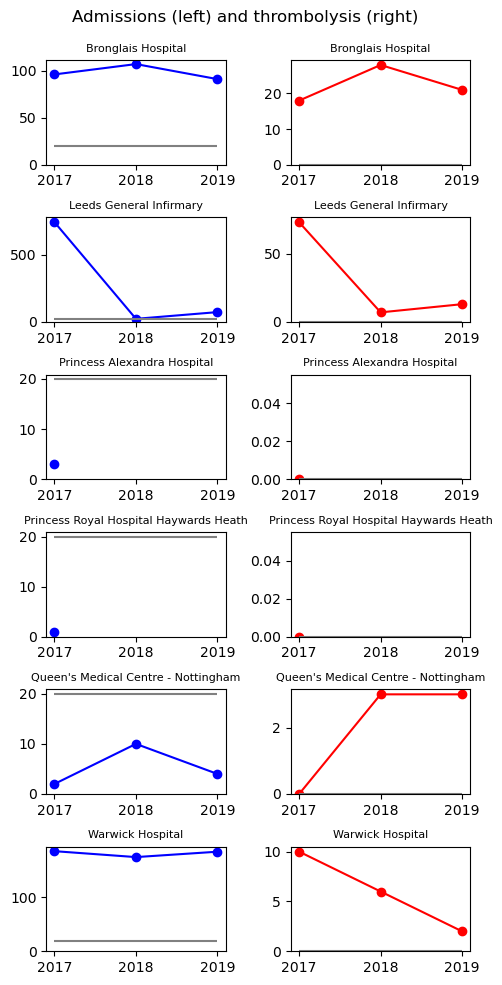

In [9]:
# Extract teams with less than 100 admissions or 3 thrombolysis per year
admissions_thrombolysis = check_criteria(
    data=raw_data_years,
    min_admissions=100,
    min_thrombolysis=3,
    output='discard')
display(admissions_thrombolysis)

# Plot this data
plot_admissions_thrombolysis(admissions_thrombolysis)

In [10]:
# Extract teams with more than 20 admissions per year
raw_data_years_size = check_criteria(
    data=raw_data_years,
    min_admissions=20,
    min_thrombolysis=0,
    output='keep')

In [11]:
# Printing number of stroke teams kept v.s. removed
n_raw_team = len(raw_data_years['stroke_team'].unique())
n_clean_team = len(raw_data_years_size['stroke_team'].unique())
print('Number of stroke teams remaining in dataset: {0}'.format(n_clean_team))
print('Number of stroke teams removed from dataset: {0}'.format(
    n_raw_team - n_clean_team
))

Number of stroke teams remaining in dataset: 115
Number of stroke teams removed from dataset: 3


## Restrict by arrival by ambulance

This project is just focussed on the **emergency stroke pathway**, and hence just on individuals who arrived by ambulance.

In [12]:
data = raw_data_years_size[raw_data_years_size['arrive_by_ambulance'] == 1]

In [13]:
# Find counts arriving by ambulance or not
arrive_ambulance_stats = (
    raw_data_years_size['arrive_by_ambulance']
    .map({0: 'Did not arrive by ambulance', 1: 'Arrived by ambulance'})
    .value_counts(dropna=False)
    .reset_index(name='count'))

# Find proportions
arrive_ambulance_stats['percentage'] = (
    arrive_ambulance_stats['count'] /
    arrive_ambulance_stats['count'].sum()*100)

arrive_ambulance_stats

,index,count,percentage
0,Arrived by ambulance,139291,79.035736
1,Did not arrive by ambulance,36947,20.964264


## Save data

In [14]:
# Save restricted dataset
filename = os.path.join(paths.data_path, paths.restrict_filename)
data.to_csv(filename)

## Appendices

### Comparing patients who arrived by ambulance to those who did not

#### Prior disability

Patients who arrived by ambulance typically had more severe strokes.

In [15]:
(raw_data_years_size
 .groupby('arrive_by_ambulance')['prior_disability']
 .describe())

,count,mean,std,min,25%,50%,75%,max
arrive_by_ambulance,,,,,,,,
0.0,36947.0,0.555823,0.984006,0.0,0.0,0.0,1.0,5.0
1.0,139291.0,1.173636,1.443219,0.0,0.0,1.0,2.0,5.0


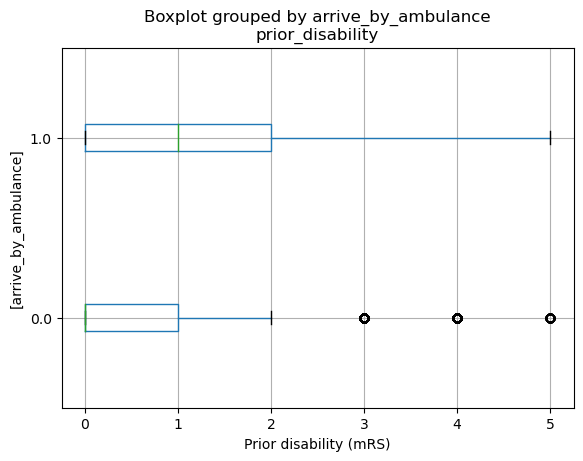

In [16]:
(raw_data_years_size[['prior_disability', 'arrive_by_ambulance']]
 .boxplot(by='arrive_by_ambulance', vert=False))
plt.xlabel('Prior disability (mRS)')
plt.show()

,arrive_by_ambulance,prior_disability,count,proportion
0,0.0,0,25368,0.143942
1,0.0,1,6078,0.034487
2,0.0,2,2865,0.016256
3,0.0,3,1909,0.010832
4,0.0,4,634,0.003597
5,0.0,5,93,0.000528
6,1.0,0,69553,0.394654
7,1.0,1,22840,0.129597
8,1.0,3,18398,0.104393
9,1.0,2,15763,0.089442


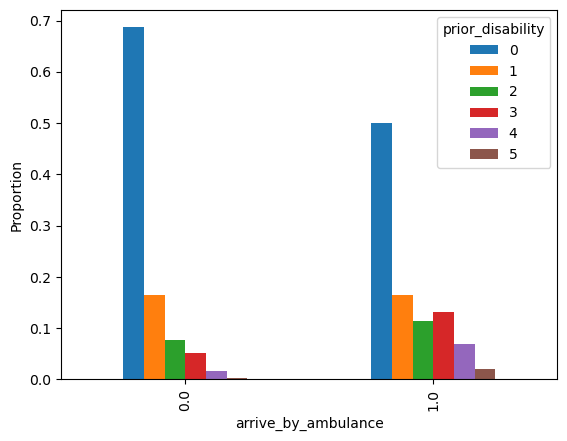

In [17]:
# Show counts and proportion of each mRS score
# (by whether arrived by ambulance)
amb_mrs = (raw_data_years_size
           .groupby('arrive_by_ambulance')['prior_disability']
           .value_counts()
           .reset_index(name='count'))
amb_mrs['proportion'] = amb_mrs['count'] / amb_mrs['count'].sum()
display(amb_mrs)

# Create grouped bar plot based on proportions
(raw_data_years_size
 .groupby('arrive_by_ambulance')['prior_disability']
 .value_counts(normalize=True)
 .unstack('prior_disability')
 .plot.bar())
plt.ylabel('Proportion')
plt.show()

#### Onset to arrival